# Heterogeneous activation time

In [1]:
include("simu_dual_utils.jl")
pyplot()    # we love pyplot!
using LaTeXStrings    # for plot labels, etc.
using JLD2

## select species

Select some of the species
1. σ₁, 2. A₁, 3. σ₂, 4. A₂, 5. R, 6. Rσ₁, 7. Rσ₂
8. σ₁ + Rσ₁, 9. σ₂ + Rσ₂, 10. R + Rσ₁ + Rσ₂

simulation #1
activation steady-state is 57.0
simulation #2
activation steady-state is 59.0
simulation #3
activation steady-state is 61.0
simulation #4
activation steady-state is 60.0
simulation #5
activation steady-state is 58.0
simulation #6
activation steady-state is 60.0
simulation #7
activation steady-state is 58.0
simulation #8
simulation #9
activation steady-state is 60.0
simulation #10
simulation #11
activation steady-state is 57.0
simulation #12
simulation #13
activation steady-state is 58.0
simulation #14
activation steady-state is 57.0
simulation #15
activation steady-state is 60.0
simulation #16
activation steady-state is 58.0
simulation #17
activation steady-state is 60.0
simulation #18
activation steady-state is 59.0
simulation #19
activation steady-state is 59.0
simulation #20
activation steady-state is 60.0
simulation #21
activation steady-state is 61.0
simulation #22
simulation #23
activation steady-state is 59.0
simulation #24
activation steady-state is 58.0
simulatio

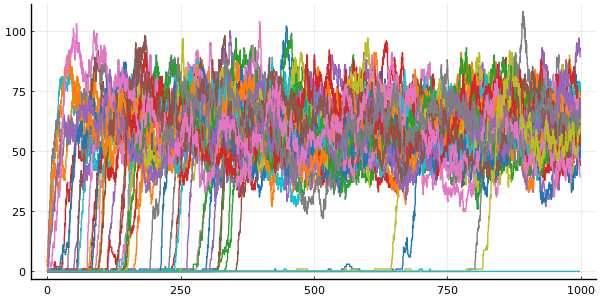

In [94]:
# settings
stress_t = 1e3
dt = 0.2

# parameters
β = 100.0
n₁ = 1.0    # both being non-cooperative
n₂ = 1.0
Rₜ = 50    # in accordance with beta

k₂ = 0.1    # k_off, molecular lifetime = 10, in accordance with sigma
k₁ = k₂ / 80    # k_on = k_off / K_d

KS = 2.0
rK = 2.0

# define the system
network = duo_ts_system()

# iteration
population = 50
act_t_vec = zeros(Float64, population)
plot()   # new plot
for i = 1:population
    sol = simu_duo_ts_all(network,
        _KS₁ = KS, _rK₁ = rK, 
        _KS₂ = 10.0, _rK₂ = 1e-12,   # sigma is turned off
        _n₁ = n₁, _n₂ = n₂,
        _Rₜ = Rₜ, 
        _k₁₁ = k₁, _k₂₁ = k₂, 
        _k₁₂ = k₁, _k₂₂ = k₂,
        _β₁ = β, _β₂ = β, _τ₁ = 10.0, _rτ = 5.0, _v₀ = 1e-3,
        # keep a sufficient length to get the activation ss
        max_t = 1e5, stress_t = stress_t, saveat = dt,
        quiet = true);    # block any plots by default
    println("simulation #", i)

    # select molecules
    # σ₁ total and Eσ₁
    # actually we only plot σ₁ total
    t, σ₁, Eσ₁ = interpret_sol(select_species(sol, [8, 6]))
    
    # find the activation value
    fp, ~, ~ = find_fp(select_species(sol, [8, 2]), stress_t, dt, β, thres_v = 2e-3)
    if size(fp, 1) > 0 && maximum(fp[:, 1]) > 0    # bistability
        act_ss = maximum(fp[:, 1])    # activation value at steady state
        println("activation steady-state is ", act_ss)
    
        # find the time of activation
        cont_t = 10    # required continuing activating time
        from = Int64(round(stress_t / dt))
        for j = from:(length(σ₁) - Int64(round(cont_t / dt)))    # not to exceed
            # activated and continue to activate for 10 time units
            if !(false in (σ₁[j:(j + Int64(round(cont_t/dt)))] .>= act_ss))
                act_t = j * dt
                act_t_vec[i] = act_t
                break
            end
        end
    else
        # no activation at all
        act_t = (length(σ₁) + 100) * dt    # represent infinity
    end

    # plot
    max_t = stress_t + 1000.0
    # originally it was min of act_t + 500 and 1000, but not really necessary to truncate
    to = Int64(round(max_t / dt))
    plot!(t[from:to] .- stress_t, σ₁[from:to], palette = :tab10)

    # we don't care about this now
    # # classification
    # regime = classify_by_timetraj(
    #     select_species(sol, [6, 2]), stress_t, dt, β, 1.0,
    #     thres_v = 0.0015,
    #     quiet = false, show_p_heatmap = true)
    # println(regime)
end

act_t_vec = [x for x in act_t_vec if x > 0] .- stress_t

# println(act_t_vec)

plot!(legend = false, size = (600, 300))


slightly modify and save figure

In [71]:
# act_t_vec_80 = act_t_vec;

In [96]:
plot!(xlabel = "Time", ylabel = "Total σ₁", grid = false)
savefig("het_activation_both_non_us.pdf")

And histogram

In [80]:
# organize into matrix
max_plot_t = 1000.
act_t_mat = zeros(4, population + 1)
# if not every traj activates, complete
act_t_mat[1, :] .= [sort(act_t_vec_10); ones(population + 1 - length(act_t_vec_10)) * max_plot_t]
act_t_mat[2, :] .= [sort(act_t_vec_20); ones(population + 1 - length(act_t_vec_20)) * max_plot_t]
act_t_mat[3, :] .= [sort(act_t_vec_40); ones(population + 1 - length(act_t_vec_40)) * max_plot_t]
act_t_mat[4, :] .= [sort(act_t_vec_80); ones(population + 1 - length(act_t_vec_80)) * max_plot_t]
act_t_mat

4×51 Matrix{Float64}:
 10.0  12.0  12.0  12.4  12.4  12.6  …   47.6   78.2  123.6   175.2  1000.0
 11.8  13.2  13.2  13.4  14.4  14.6     371.2  390.8  538.0  1000.0  1000.0
  8.2   8.6   8.8  10.0  10.0  10.6     495.2  537.0  599.2   905.2  1000.0
  3.6   6.6   8.4   9.8  11.0  11.0     706.2  735.4  741.2   946.8  1000.0

In [82]:
# save data

# save("accumulated_het_act_both_non_bs.jld2", 
#     Dict("act_t_mat" => act_t_mat, "Kd" => [10, 20, 40, 80]))

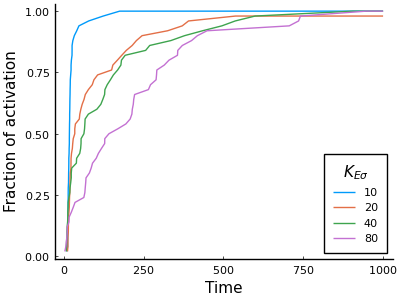

In [91]:
# extend the last value to max_plot_t
Kd_vec = [10, 20, 40, 80]
p_acc = plot()
for i = 1:length(Kd_vec)
    n_max = sum(act_t_mat[i, :] .== max_plot_t)
    accumulation = [1:(population + 1 - n_max); ones(n_max) .* (population + 1 - n_max)] ./ population
    plot!(p_acc, act_t_mat[i, :], accumulation, label = Kd_vec[i])
end
plot!(p_acc, legendtitle = L"K_{Eσ}", grid = false, size = (400, 300),
    legend = :bottomright)
plot!(p_acc, xlabel = "Time", ylabel = "Fraction of activation")

In [92]:
savefig(p_acc, "fraction_act_both_non_bs.pdf")